In [1]:
require(tidyverse)
require(stringr)
require(janitor)
require(forcats)
require(viridis)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: janitor
Loading required package: viridis
Loading required package: viridisLite


# Overview

This notebook contains R code for batch plotting of MIDs from example files.  It works by:

1. importing a smallish .csv file created to list, row-by-row, a name, monoisotopic `mz`, manually specified RT window (`manual_rt_min` and `manual_rt_max`), a manually specified max number of heavy neutrons to consider (`manual_span`), and a `charge` for the ion of interest.

2. From this file, generate a list of independent command-line calls to `python get_MID.py`.
  * Also at this step, the notebook creates directories for storing the .csv files from the next step in a meaningful directory structure.

3. Using R's `system()` command, execute these calls.

4. Read the resulting .csv files into a single dataframe.

5. Plot the results with `ggplot()`.


* Caveat: no effort has made to make filepaths and directory names generic and portable.  If you use this notebook you will have to tweak things for your local environment!

### 1. Import .csv file of features for which MIDs should be extracted

In [2]:
setwd('~/Box/2018_D2O_manuscript/jupyter/')
hits <- read_csv('saved_data/top_20_labeled_features_homoharringtonine_manual_annot.csv') %>%
    clean_names %>%
    na.omit()

Parsed with column specification:
cols(
  name = col_character(),
  mz = col_double(),
  rtmed = col_double(),
  manual_rt_min = col_double(),
  manual_rt_max = col_double(),
  manual_span = col_integer(),
  charge = col_integer(),
  formula = col_character()
)


In [3]:
hits

name,mz,rtmed,manual_rt_min,manual_rt_max,manual_span,charge,formula
M139T631,139.0390,10.511692,10.3,10.8,3,1,C7H7O3+
M163T380,163.0389,6.331000,6.1,6.7,4,1,C9H7O3+
M205T219,205.0971,3.655875,3.3,3.9,6,1,C11H13N2O2+
M310T1106_1,310.1414,18.439758,18.3,18.7,7,2,unknown
M433T969_1,433.1128,16.151158,16.0,16.4,4,1,C21H21O10+
M449T970,449.1078,16.164825,16.0,16.4,7,1,C21H21O11+
M449T952,449.1081,15.859600,15.7,16.0,7,1,C21H21O11+
M502T837_1,502.2441,13.950617,13.8,14.2,7,1,C27H36NO8+
M516T931_1,516.2601,15.521333,15.4,15.8,9,1,C28H38NO8+


### 2. Generate calls to `get_MID.py`

In [4]:
files <- 
    list(labeled = '~/Box/2018_D2O_manuscript/mzml_files/homoharringtonine_case_study/180501-KS-I-17-Dnew-A.mzML',
         unlabeled = '~/Box/2018_D2O_manuscript/mzml_files/homoharringtonine_case_study/180412-KS-I-9-control-1.mzML')


command_list <- c()

for(file_ref in names(files)){
    mzml_file <- files[file_ref]
    
    for(idx in 1:nrow(hits)){
        f <- mzml_file
        d <- hits[[idx, 'mz']]
        z <- hits[[idx, 'charge']]
        r <- hits[[idx, 'manual_rt_min']]
        t <- hits[[idx, 'manual_rt_max']]
        n <- hits[[idx, 'manual_span']]
        out_fname <- hits[[idx, 'name']]
        
        # file i/o
        dirname <- paste('~/Box/2018_D2O_manuscript/jupyter/saved_data/mids/', file_ref, sep='')
        ifelse(!dir.exists(dirname), dir.create(dirname, recursive = TRUE), FALSE)
        o <- paste(dirname, 
                   '/', 
                   out_fname, 
                   '.csv', 
                   sep='')
        
        # tabulate commands
        this_command <- paste('source activate py36; python get_MID.py -f', f, 
                              '-d', d,
                              '-z', z,
                              '-r', r,
                              '-t', t,
                              '-o', o,
                              sep=' ')
        command_list <-  c(command_list, this_command)
    }
}

### 3. Execute the commands using R's `system()` command.

(N.B. This was the fastest/easiest way for me to do this, not the most secure or scalable.)

In [5]:
setwd('~/stanford/code/sattely_lab_github/scripts/')
for(cmd in command_list){
    print(cmd)
    system(cmd)
}

[1] "source activate py36; python get_MID.py -f ~/Box/2018_D2O_manuscript/mzml_files/homoharringtonine_case_study/180501-KS-I-17-Dnew-A.mzML -d 139.0389614 -z 1 -r 10.3 -t 10.8 -o ~/Box/2018_D2O_manuscript/jupyter/saved_data/mids/labeled/M139T631.csv"
[1] "source activate py36; python get_MID.py -f ~/Box/2018_D2O_manuscript/mzml_files/homoharringtonine_case_study/180501-KS-I-17-Dnew-A.mzML -d 163.0388782 -z 1 -r 6.1 -t 6.7 -o ~/Box/2018_D2O_manuscript/jupyter/saved_data/mids/labeled/M163T380.csv"
[1] "source activate py36; python get_MID.py -f ~/Box/2018_D2O_manuscript/mzml_files/homoharringtonine_case_study/180501-KS-I-17-Dnew-A.mzML -d 205.0970761 -z 1 -r 3.3 -t 3.9 -o ~/Box/2018_D2O_manuscript/jupyter/saved_data/mids/labeled/M205T219.csv"
[1] "source activate py36; python get_MID.py -f ~/Box/2018_D2O_manuscript/mzml_files/homoharringtonine_case_study/180501-KS-I-17-Dnew-A.mzML -d 310.1414445 -z 2 -r 18.3 -t 18.7 -o ~/Box/2018_D2O_manuscript/jupyter/saved_data/mids/labeled/M310T1106_

### 4. Read all the various .csv files into a single dataframe.

In [7]:
all_df <- 
    do.call(bind_rows,
            lapply(list.files(path = "~/Box/2018_D2O_manuscript/jupyter/saved_data/mids",
                            pattern = "*.csv",
                            full.names = TRUE,
                            recursive = TRUE
                           ),
                   read_csv)
           ) %>%
    clean_names 

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  H2_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  H2_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  H2_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""

### 5. Plot the data with `ggplot()`

Warning message in dir.create("~/Box/2018_D2O_manuscript/figures/untarg_analysis"):
“'/Users/curt/Box/2018_D2O_manuscript/figures/untarg_analysis' already exists”

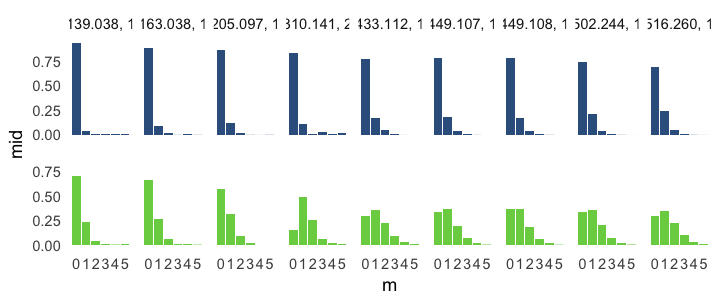

In [8]:
options(repr.plot.width=6, repr.plot.height=2.5)
all_df %>%
    mutate(structure = str_replace(structure, '[_]', ', ')) %>%
    mutate(structure = str_replace(structure, '(?<=[.][0-9]{3})[0-9]*', '')) %>%
    ggplot(aes(x=m, y=mid, fill=mzml_file)) +
        geom_bar(stat='identity') +
        scale_x_continuous(breaks = 0:6) +
        facet_grid(mzml_file ~ structure, scale='free_x') +
        theme_minimal() +
        theme(legend.position='none',
              panel.grid = element_blank(),
              strip.text.y = element_blank(),
              ) +
        scale_fill_viridis(discrete=T, begin = 0.3, end=0.8)

dir.create('~/Box/2018_D2O_manuscript/figures/untarg_analysis')
ggsave('~/Box/2018_D2O_manuscript/figures/untarg_analysis/top_mids.pdf', width=6, height=2.5)

The plot above is essentially a subfigure in the paper; of course the version in the paper is lightly edited for readability and formatting.